## Attention over MNIST Digits: Find the Largest Digit

In this notebook, we will revisit the MNIST dataset, but instead of performing digit classification as usual, we will explore how to use the **attention mechanism** in a simple but powerful way.

### Task Description

We create a **collection of MNIST digit images** (e.g., a sequence of 3–5 digits), and the task is:

> **Select the largest digit in the collection using attention.**

This is a simplified and intuitive example to demonstrate how attention can be used to **focus on important parts of an input**, not just in language tasks, but also in vision tasks.

#### Credit

This idea is inspired by Edward Raff  
👉 [GitHub: EdwardRaff](https://github.com/EdwardRaff)

We’ll go through:
- Preparing the dataset (sequences of digits)
- Building an attention-based model
- Training it to select the largest digit
- Visualizing what the model attends to

Let’s get started!


In [2]:
# Import statments
import numpy as np
import torch
import torchvision
from torchvision import transforms

In [3]:
# Download the training and testing MNIST data
# Store them as PyTorch tensors
mnist_train = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 7.93MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 353kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.34MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.28MB/s]


##  What are `Dataset` and `DataLoader` in PyTorch?

So far, we've been using `ToTensor()` to convert raw inputs (NumPy) into tensors. But when working with many inputs, large datasets (like in MNIST), we need a clean and efficient way to:

- Load all the images
- Shuffle them for training
- Group them into batches
- Feed them into the model automatically

This is where **`Dataset`** and **`DataLoader`** come in!


### `Dataset`: Think of it as a list of (input, label) pairs
PyTorch provides a class called `torch.utils.data.Dataset`, which acts like a **container for your data**.


#### How Do I Build a Custom Dataset?

To create a new type of dataset in PyTorch, we **subclass** `torch.utils.data.Dataset` and implement **three required methods**:

1. `__init__(self, ...)`:  
   - Called **once** when the dataset is created
   - Here we store the original dataset (e.g., MNIST), and how many digits we want to select each time

2. `__len__(self)`:  
   - Tells PyTorch how many items are in our dataset  
   - Often just returns the length of the original dataset

3. `__getitem__(self, item)`:  
   - This is called when PyTorch wants to **get one item** (an input-label pair)
   - We define what that looks like: here, we’ll randomly pick `n` images and return the **group of images** and the **largest digit** among them

In [1]:
from torch.utils.data import Dataset, DataLoader

class LargestDigit(Dataset):
    """
    Creates a modified version of a dataset where some number of samples are taken, 
    and the true label is the largest label sampled. When used with MNIST the labels 
    correspond to their values (e.g., digit "6" has label 6)
    """

    def __init__(self, dataset, toSample=3):
        """
        dataset: the dataset to sample from
        toSample: the number of items from the dataset to sample
        """
        self.dataset = dataset
        self.toSample = toSample

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        # Randomly select n=self.toSample items from the dataset
        selected = np.random.randint(0, len(self.dataset), size=self.toSample)
        
        # Stack the n items of shape (B, *) shape into (B, n, *)
        x_new = torch.stack([self.dataset[i][0] for i in selected])
        # Label is the maximum label
        y_new = max([self.dataset[i][1] for i in selected])
        # Return (data, label) pair!
        return x_new, y_new

In [4]:
# Create an instance of our custom dataset
# for both the training and testing dataset
largest_train = LargestDigit(mnist_train)
largest_test = LargestDigit(mnist_test)

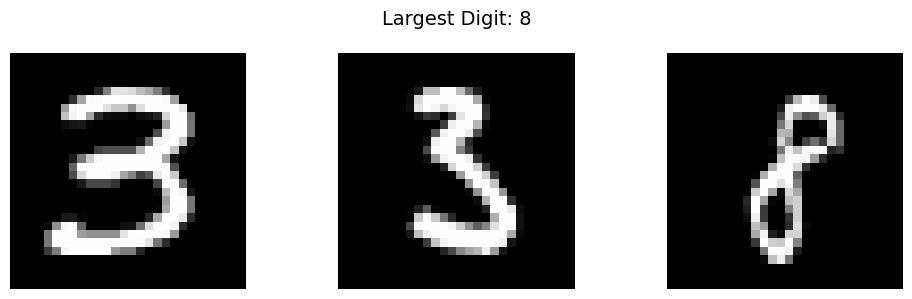

In [9]:
import matplotlib.pyplot as plt

# Sample a single (image group, label) pair
sample_imgs, sample_label = largest_train[0]  # sample_imgs shape: (3, 1, 28, 28)

# Plot the 3 digits side by side
fig, axs = plt.subplots(1, sample_imgs.size(0), figsize=(10, 3))
for i in range(sample_imgs.size(0)):
    axs[i].imshow(sample_imgs[i][0], cmap='gray')  # [0] to remove channel dim
    axs[i].axis('off')

plt.suptitle(f"Largest Digit: {sample_label}", fontsize=14)
plt.tight_layout()
plt.show()

### Now let's train a simple feed forward network on this task 

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy

# Create the DataLoader
train_loader = DataLoader(largest_train, batch_size=64, shuffle=True)

# -------------------------------
# 4. Define the model
# -------------------------------
neurons = 256
classes = 10

simpleNet = nn.Sequential(
    nn.Flatten(),  # (3, 1, 28, 28) → (3*784,)
    nn.Linear(784*3, neurons),
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons, neurons),
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons, neurons),
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons, classes)
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = simpleNet.to(device)

# -------------------------------
# 5. Define loss and optimizer
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

# -------------------------------
# 6. Training loop with accuracy
# -------------------------------
from torchmetrics.classification import MulticlassAccuracy

epochs = 10
loss_vals = []
train_acc_vals = []

accuracy_metric = MulticlassAccuracy(num_classes=10).to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    accuracy_metric.reset()

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.view(x_batch.size(0), -1).to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        y_pred = model(x_batch)

        # Loss
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item()

        # Accuracy update
        accuracy_metric.update(y_pred, y_batch)

        # Backprop + step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    avg_acc = accuracy_metric.compute().item()

    loss_vals.append(avg_loss)
    train_acc_vals.append(avg_acc)

    print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f} | Train Accuracy: {avg_acc:.4f}")

Epoch  1 | Loss: 0.9883 | Train Accuracy: 0.4986
Epoch  2 | Loss: 0.6720 | Train Accuracy: 0.6468
Epoch  3 | Loss: 0.5442 | Train Accuracy: 0.7306
Epoch  4 | Loss: 0.4580 | Train Accuracy: 0.7629
Epoch  5 | Loss: 0.4142 | Train Accuracy: 0.8007
Epoch  6 | Loss: 0.3819 | Train Accuracy: 0.8094
Epoch  7 | Loss: 0.3496 | Train Accuracy: 0.8283
Epoch  8 | Loss: 0.3210 | Train Accuracy: 0.8379
Epoch  9 | Loss: 0.3033 | Train Accuracy: 0.8539
Epoch 10 | Loss: 0.2901 | Train Accuracy: 0.8375


In [28]:
from torchmetrics.classification import MulticlassAccuracy

# Create the test DataLoader
test_loader = DataLoader(largest_test, batch_size=64, shuffle=True)

# Define accuracy metric
test_accuracy = MulticlassAccuracy(num_classes=10).to(device)

# Put model in evaluation mode
model.eval()

# Reset metric just in case
test_accuracy.reset()

# Disable gradient tracking
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.view(x_batch.size(0), -1).to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)
        test_accuracy.update(y_pred, y_batch)

# Compute final accuracy
final_test_acc = test_accuracy.compute().item()
print(f"Final Test Accuracy: {final_test_acc:.4f}")


Final Test Accuracy: 0.9054


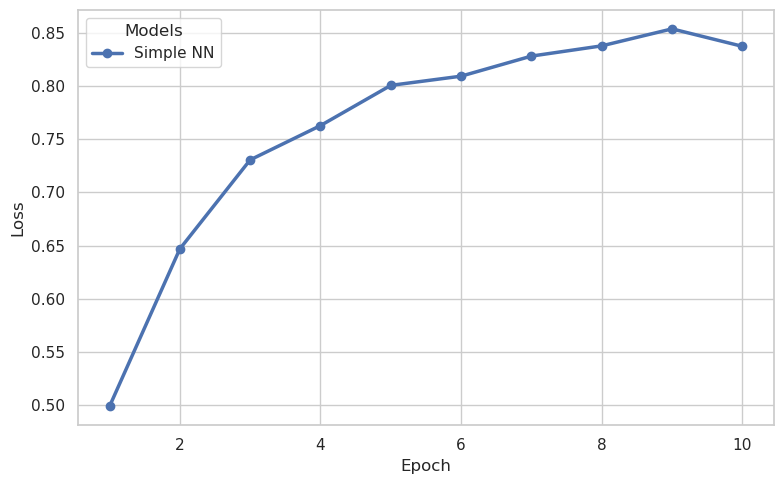

In [29]:
# -------------------------------
# 7. Plot loss curve 
# -------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# Prepare long-form DataFrame
loss_simple_nn = pd.DataFrame({
    "epochs": list(range(1, epochs + 1)),
    "loss": loss_vals,
    "acc": train_acc_vals
})

plt.figure(figsize=(8, 5))
plt.plot(loss_simple_nn.epochs, loss_simple_nn.acc, label="Simple NN", marker='o', linewidth=2.5)

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(title="Models")  # Add a legend
plt.grid(True)
plt.tight_layout()
plt.show()


## Let's Implement a Simple Attention Mechanism

Up until now, we've built neural networks that treat all inputs equally — every digit in our sequence contributes the same way.

But what if we could tell the network:
> "Pay more attention to the most important digit in the group"?

This is where **attention** comes in.


### What We'll Do

We’re going to implement a **simple form of attention**:
- We'll pass each digit through a small neural network to get a **hidden representation**
- We'll compute a **score** for each digit using a scoring function
- Then apply a **softmax** to turn those scores into **attention weights**
- Finally, we take a **weighted sum** of the digit features to get a **context vector** — the representation the model will use to make its decision


### What's Happening Visually

Take a look at the diagram above 👆:

- Each input $x_i$ is processed into a hidden state $h_i$
- We compute scores like $s_i = \text{score}(h_i)$
- Then convert them into attention weights $\alpha_i = \text{softmax}(s_i)$
- The final output is a **weighted sum**:

$$
\text{Context} = \sum_i \alpha_i \cdot h_i
$$

This **context vector** summarizes the information in the sequence, weighted by relevance.

👉 Let's now implement this attention mechanism in code and see how well it helps the model **focus on the largest digit**.


In [30]:
# -------------------------------
# 1. Custom Flatten Layer
# -------------------------------
class CustomFlatten(nn.Module):
    """
    Flattens all dimensions after the first two:
    Input:  (B, T, C, H, W)
    Output: (B, T, C*H*W)
    """
    def forward(self, x):
        return x.view(x.size(0), x.size(1), -1)
    

# -------------------------------
# 2. Combiner Module
# -------------------------------    
class Combiner(nn.Module):
    """
    Combines:
    - Feature extractor F to produce representations h_i = F(x_i)
    - Attention mechanism W to produce importance weights alpha_i
    Then returns weighted sum of features:
        output = sum_i(alpha_i * h_i)
    """

    def __init__(self, featureExtraction, weightSelection):
        super(Combiner, self).__init__()
        self.featureExtraction = featureExtraction
        self.weightSelection = weightSelection

    def forward(self, x):
        # x shape: (B, T, D), where T = number of digits per sample

        # Step 1: Extract features for each digit: h_i = F(x_i)
        features = self.featureExtraction(x)  # shape: (B, T, neurons)

        # Step 2: Get attention scores alpha_i = softmax(score(h_i))
        weights = self.weightSelection(features)  # shape: (B, T, 1) or (B, T)

        # Ensure shape is (B, T, 1) for broadcasting
        if weights.dim() == 2:
            weights = weights.unsqueeze(2)

        # Step 3: Element-wise product of alpha_i * h_i
        weighted_features = features * weights  # shape: (B, T, neurons)

        # Step 4: Sum over the digits (T axis) → final context vector
        return torch.sum(weighted_features, dim=1)  # shape: (B, neurons)

In [32]:
neurons = 256     # Hidden dimensionality used in feature representations
classes = 10      # Output classes (digits 0–9)
D = 784           # Flattened input per digit (28×28)

# The backbone feature extractor
# Learns a feature representation $h_i$ for each digit
BackboneNetwork = nn.Sequential(
    CustomFlatten(),  # (B, T, 1, 28, 28) → (B, T, 784), flattens each digit
    # Linear layers apply the same network to each digit to compute h_i
    nn.Linear(D, neurons),       # maps 784 → 256
    nn.LeakyReLU(),
    nn.Linear(neurons, neurons), # 256 → 256
    nn.LeakyReLU(),
    nn.Linear(neurons, neurons), # 256 → 256 again
    nn.LeakyReLU(),
    # Output: (B, T, neurons) = feature for each digit in the bag
)

# The Score function
# Computes attention scores $\alpha_i$ for each digit
SimpleAttentionMechanism = nn.Sequential(
    nn.Linear(neurons, neurons),  # input: h_i of size 256 → hidden layer
    nn.LeakyReLU(),
    nn.Linear(neurons, 1),        # output one score per digit (B, T, 1)
    nn.Softmax(dim=1)             # softmax over T → get valid attention weights α_i
)

# Our Network with the Simple Attention
SimpleAttentionNetwok = nn.Sequential(
    # Step 1: Use Combiner to apply attention over digit features
    Combiner(BackboneNetwork, SimpleAttentionMechanism),  # input: (B, T, C, H, W) → output: (B, 256)
    # Step 2: Fully connected classifier on context vector
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons, neurons),
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons, classes)  # final output: logits for 10 classes
)

### Now let's train a network with simple attention

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleAttentionNetwok.to(device)

# -------------------------------
# 5. Define loss and optimizer
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

# -------------------------------
# 6. Training loop with accuracy
# -------------------------------
epochs = 10
loss_vals = []
train_acc_vals = []

accuracy_metric = MulticlassAccuracy(num_classes=10).to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    accuracy_metric.reset()

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)  # shape: (B, T, 1, 28, 28)
        y_batch = y_batch.to(device)

        # Forward pass
        y_pred = model(x_batch)  # Output: (B, 10)

        # Compute loss
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item()

        # Update accuracy
        accuracy_metric.update(y_pred, y_batch)

        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # End-of-epoch stats
    avg_loss = total_loss / len(train_loader)
    avg_acc = accuracy_metric.compute().item()

    loss_vals.append(avg_loss)
    train_acc_vals.append(avg_acc)

    print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f} | Train Accuracy: {avg_acc:.4f}")

Epoch  1 | Loss: 0.4100 | Train Accuracy: 0.7371
Epoch  2 | Loss: 0.1562 | Train Accuracy: 0.9030
Epoch  3 | Loss: 0.1085 | Train Accuracy: 0.9390
Epoch  4 | Loss: 0.0827 | Train Accuracy: 0.9408
Epoch  5 | Loss: 0.0666 | Train Accuracy: 0.9624
Epoch  6 | Loss: 0.0544 | Train Accuracy: 0.9674
Epoch  7 | Loss: 0.0427 | Train Accuracy: 0.9716
Epoch  8 | Loss: 0.0363 | Train Accuracy: 0.9802
Epoch  9 | Loss: 0.0339 | Train Accuracy: 0.9797
Epoch 10 | Loss: 0.0262 | Train Accuracy: 0.9827


In [35]:
from torchmetrics.classification import MulticlassAccuracy

# Create the test DataLoader
test_loader = DataLoader(largest_test, batch_size=64, shuffle=True)

# Define accuracy metric
test_accuracy = MulticlassAccuracy(num_classes=10).to(device)

# Put model in evaluation mode
model.eval()

# Reset metric just in case
test_accuracy.reset()

# Disable gradient tracking
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)
        test_accuracy.update(y_pred, y_batch)

# Compute final accuracy
final_test_acc = test_accuracy.compute().item()
print(f"Final Test Accuracy: {final_test_acc:.4f}")

Final Test Accuracy: 0.9706


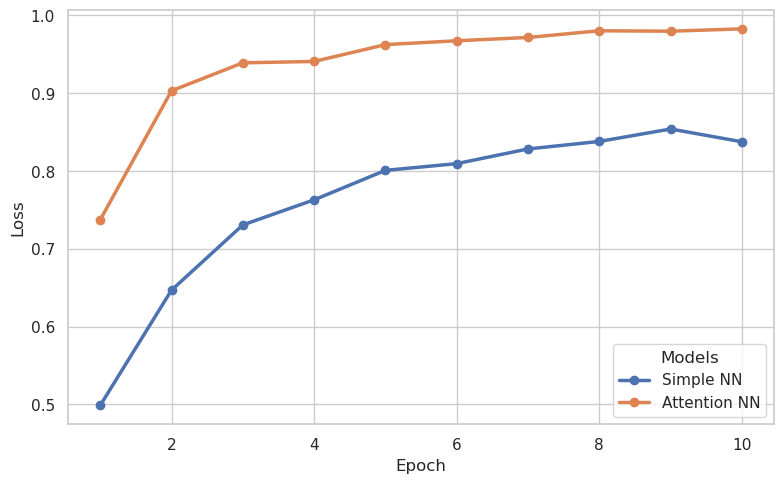

In [36]:
# -------------------------------
# 7. Plot loss curve 
# -------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# Prepare long-form DataFrame
loss_attention_nn = pd.DataFrame({
    "epochs": list(range(1, epochs + 1)),
    "loss": loss_vals,
    "acc": train_acc_vals
})

plt.figure(figsize=(8, 5))
plt.plot(loss_simple_nn.epochs, loss_simple_nn.acc, label="Simple NN", marker='o', linewidth=2.5)
plt.plot(loss_attention_nn.epochs, loss_attention_nn.acc, label="Attention NN", marker='o', linewidth=2.5)

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(title="Models")  # Add a legend
plt.grid(True)
plt.tight_layout()
plt.show()


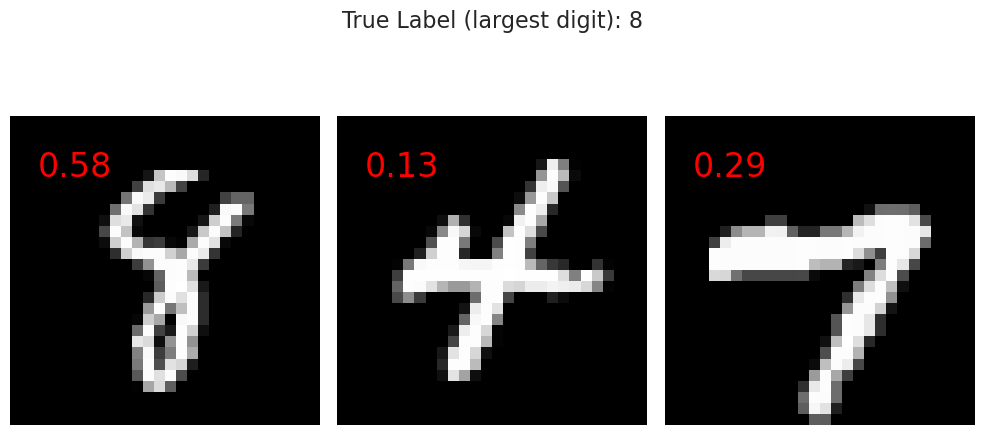

In [37]:
import matplotlib.pyplot as plt

# -----------------------------------
# 1. Select a sample from the dataset
# -----------------------------------
x, y = largest_train[0]  # x shape: (T=3, 1, 28, 28)
x = x.to(device)         # move to same device as model

# -----------------------------------
# 2. Run through Backbone and Attention Mechanism
# -----------------------------------
with torch.no_grad():
    # Add batch dimension: (1, T, 1, 28, 28)
    x_batch = x.unsqueeze(0)

    # Step 1: Get feature vectors h_i using the backbone
    features = BackboneNetwork(x_batch)  # shape: (1, T, neurons)

    # Step 2: Get attention weights α_i using the attention mechanism
    weights = SimpleAttentionMechanism(features)  # shape: (1, T, 1)
    weights = weights.cpu().numpy().ravel()       # flatten to (T,)

# -----------------------------------
# 3. Plot the digits with their attention scores
# -----------------------------------
f, axarr = plt.subplots(1, 3, figsize=(10, 5))

for i in range(3):
    axarr[i].imshow(x[i, 0].cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    axarr[i].axis('off')
    axarr[i].text(2, 5, str(round(weights[i], 2)), color='red', fontsize=24)

plt.suptitle(f"True Label (largest digit): {y}", fontsize=16)
plt.tight_layout()
plt.show()


## From Simple to Multi-Head Attention

So far, we’ve implemented a **simple attention mechanism**:  
We computed a single attention score for each digit and used those scores to combine their features.

Now we’ll take this a step further and implement **Multi-Head Attention**, following the clear and elegant design from:

🔗 [Sebastian Raschka’s LLMs-from-scratch: Multihead Attention](https://github.com/rasbt/LLMs-from-scratch/blob/main/ch03/01_main-chapter-code/multihead-attention.ipynb)


### What’s the Idea Behind Multi-Head Attention?

Instead of using **one attention mechanism**, we use **multiple "heads" in parallel**.

Each head:
- Computes its own attention weights
- Looks at the input from a slightly different perspective
- Learns different relationships between elements in the input (e.g., digits)

Then:
- We **concatenate the outputs** from all heads
- Project them into a final output space


### Why Multi-Head?

> Multi-head attention gives the model more flexibility to **attend to different patterns** in the input simultaneously — this is critical in large-scale models like Transformers.


### What We’ll Do

We'll build:
- A custom **MultiHeadAttention** module that wraps several attention heads
- A way to combine their outputs into a **single context vector**
- A model that uses this new attention block to make better decisions

Let’s now implement Multi-Head Attention from scratch, step-by-step 

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads=4, dropout=0.1, qkv_bias=False):
        """
        Multi-Head Attention module without causal masking.
        
        Parameters:
        - d_model:    Input and output dimensionality (same for Q, K, V, and final output)
        - num_heads:  Number of parallel attention heads
        - dropout:    Dropout applied to attention weights
        - qkv_bias:   Whether to include bias in Q, K, V projections
        """
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads  # Dimensionality of each head

        # Projection layers for Q, K, V — project from d_model → d_model
        self.W_query = nn.Linear(d_model, d_model, bias=qkv_bias)
        self.W_key   = nn.Linear(d_model, d_model, bias=qkv_bias)
        self.W_value = nn.Linear(d_model, d_model, bias=qkv_bias)

        # Final linear layer after concatenating all heads
        self.out_proj = nn.Linear(d_model, d_model)

        # Dropout after softmax attention weights
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Parameters:
        - x: Tensor of shape (batch_size, seq_len, d_model)

        Returns:
        - context_vec: Tensor of shape (batch_size, seq_len, d_model)
        """
        B, T, _ = x.shape  # B = batch size, T = number of tokens

        # Compute Q, K, V projections: shape → (B, T, d_model)
        Q = self.W_query(x)
        K = self.W_key(x)
        V = self.W_value(x)

        # Reshape and transpose for multi-head attention:
        # From (B, T, d_model) → (B, num_heads, T, head_dim)
        Q = Q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention scores: (B, num_heads, T, T)
        attn_scores = Q @ K.transpose(-2, -1) / (self.head_dim ** 0.5)

        # Softmax to get attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)
        #attn_weights = self.dropout(attn_weights)

        # Weighted sum of values: (B, num_heads, T, head_dim)
        context = attn_weights @ V

        # Transpose + reshape: (B, T, d_model)
        context = context.transpose(1, 2).contiguous().view(B, T, self.d_model)

        # Final linear projection
        context_vec = self.out_proj(context)

        return context_vec

In [40]:
mha = MultiHeadAttention(d_model=256, num_heads=4)
x = torch.randn(32, 3, 256)  # (batch, num_tokens, d_model)
output = mha(x)              # output shape: (32, 3, 256)
print(output.shape)

torch.Size([32, 3, 256])


### Now let's train an advanced network with a mult-head attention

In [44]:
import torch.nn as nn

class LargestDigitClassifierMHA(nn.Module):
    def __init__(self, d_model=256, num_heads=4, num_classes=10):
        super().__init__()

        # Flatten image: 1×28×28 → 784, then project to d_model
        self.flatten_and_project = nn.Sequential(
            nn.Flatten(start_dim=2),             # (B, T, 1, 28, 28) → (B, T, 784)
            nn.Linear(784, d_model),             # (B, T, 784) → (B, T, d_model)
            nn.ReLU()
        )

        # Multi-head self-attention
        self.attn = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

        # Final classifier: based on aggregated context vector
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        """
        x: shape (B, T, 1, 28, 28)
        returns: logits of shape (B, num_classes)
        """
        # Step 1: Flatten and project digits to d_model
        x = self.flatten_and_project(x)  # shape: (B, T, d_model)

        # Step 2: Apply multi-head attention
        x = self.attn(x)  # shape: (B, T, d_model)

        # Step 3: Aggregate across digits (mean pooling)
        context = x.mean(dim=1)  # shape: (B, d_model)

        # Step 4: Classification
        logits = self.classifier(context)  # shape: (B, num_classes)
        return logits

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LargestDigitClassifierMHA().to(device)

# -------------------------------
# 5. Define loss and optimizer
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

# -------------------------------
# 6. Training loop with accuracy
# -------------------------------
epochs = 10
loss_vals = []
train_acc_vals = []

accuracy_metric = MulticlassAccuracy(num_classes=10).to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    accuracy_metric.reset()

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)  # shape: (B, T, 1, 28, 28)
        y_batch = y_batch.to(device)

        # Forward pass
        y_pred = model(x_batch)  # Output: (B, 10)

        # Compute loss
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item()

        # Update accuracy
        accuracy_metric.update(y_pred, y_batch)

        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # End-of-epoch stats
    avg_loss = total_loss / len(train_loader)
    avg_acc = accuracy_metric.compute().item()

    loss_vals.append(avg_loss)
    train_acc_vals.append(avg_acc)

    print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f} | Train Accuracy: {avg_acc:.4f}")

Epoch  1 | Loss: 0.5709 | Train Accuracy: 0.6534
Epoch  2 | Loss: 0.2181 | Train Accuracy: 0.8616
Epoch  3 | Loss: 0.1477 | Train Accuracy: 0.9137
Epoch  4 | Loss: 0.1120 | Train Accuracy: 0.9341
Epoch  5 | Loss: 0.0893 | Train Accuracy: 0.9489
Epoch  6 | Loss: 0.0765 | Train Accuracy: 0.9505
Epoch  7 | Loss: 0.0661 | Train Accuracy: 0.9609
Epoch  8 | Loss: 0.0581 | Train Accuracy: 0.9626
Epoch  9 | Loss: 0.0494 | Train Accuracy: 0.9660
Epoch 10 | Loss: 0.0435 | Train Accuracy: 0.9745


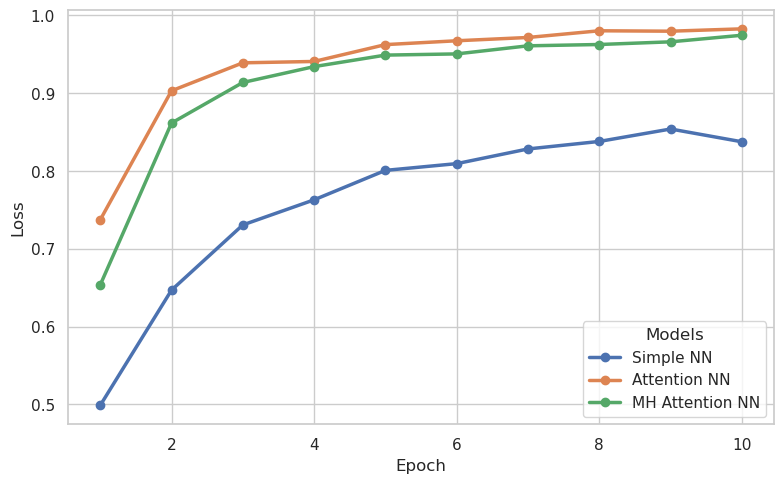

In [47]:
# -------------------------------
# Plot loss curve 
# -------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# Prepare long-form DataFrame
loss__mha_attention_nn = pd.DataFrame({
    "epochs": list(range(1, epochs + 1)),
    "loss": loss_vals,
    "acc": train_acc_vals
})

plt.figure(figsize=(8, 5))
plt.plot(loss_simple_nn.epochs, loss_simple_nn.acc, label="Simple NN", marker='o', linewidth=2.5)
plt.plot(loss_attention_nn.epochs, loss_attention_nn.acc, label="Attention NN", marker='o', linewidth=2.5)
plt.plot(loss__mha_attention_nn.epochs, loss__mha_attention_nn.acc, label="MH Attention NN", marker='o', linewidth=2.5)

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(title="Models")  # Add a legend
plt.grid(True)
plt.tight_layout()
plt.show()


## 🚀 Let's Build Our Own GPT Model!

Now that we’ve explored attention and how it helps neural networks **focus on what's important**, we’re ready to take the next big leap:

> We're going to **build our own GPT model from scratch!** 🤯


### What's GPT?

GPT stands for **Generative Pretrained Transformer** — a model that uses the Transformer decoder architecture to:
- Learn from sequences of data (like digits, text, tokens)
- Predict the next item in a sequence
- Power incredible systems like ChatGPT, Copilot, and more!


### What We'll Build

We'll create a **minimal but functional GPT block**, following the real architecture:
- **Multi-Head Self-Attention**
- **LayerNorm and Residual Connections**
- **Feed-Forward MLPs**
- (and later maybe **Positional Encoding**)

By the end of this, you'll not only understand how GPT works —  
you’ll have built it with your own hands

**Let's do this!**


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GPTBlock(nn.Module):
    def __init__(self, d_model, num_heads=4, mlp_ratio=4.0, dropout=0.1):
        """
        A minimal GPT block = LN → Multi-Head Attention → Add → LN → MLP → Add

        Args:
            d_model:     input/output dimension of the model
            num_heads:   number of attention heads
            mlp_ratio:   how much to expand in the feed-forward block (FFN hidden = d_model * mlp_ratio)
            dropout:     dropout rate
        """
        super().__init__()

        # LayerNorm before attention
        self.norm1 = nn.LayerNorm(d_model)

        # Multi-Head Self-Attention
        self.attn = MultiHeadAttention(d_model=d_model, num_heads=num_heads, dropout=dropout)

        # LayerNorm before MLP
        self.norm2 = nn.LayerNorm(d_model)

        # MLP = feed-forward block (typically 2 linear layers with ReLU or GELU)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, int(mlp_ratio * d_model)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(mlp_ratio * d_model), d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # x: shape (B, T, d_model)

        # LayerNorm → Attention → Add
        x = x + self.attn(self.norm1(x))

        # LayerNorm → MLP → Add
        x = x + self.mlp(self.norm2(x))

        return x

## 🚀 We Can Build as Well Our Own GPT-2 small Model!

In [42]:
import torch
import torch.nn as nn

class GPT2Block(nn.Module):
    def __init__(self, d_model, n_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadAttention(d_model, num_heads=n_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, int(mlp_ratio * d_model)),
            nn.GELU(),
            nn.Linear(int(mlp_ratio * d_model), d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class GPT2(nn.Module):
    def __init__(self, vocab_size=50257, block_size=1024, n_layer=12, n_head=12, d_model=768, dropout=0.1):
        super().__init__()

        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(block_size, d_model)
        self.drop = nn.Dropout(dropout)

        self.blocks = nn.Sequential(*[
            GPT2Block(d_model=d_model, n_heads=n_head, dropout=dropout)
            for _ in range(n_layer)
        ])

        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

        self.block_size = block_size

    def forward(self, idx):
        B, T = idx.shape
        assert T <= self.block_size, "Sequence too long"

        pos = torch.arange(0, T, device=idx.device).unsqueeze(0)  # (1, T)

        x = self.token_embed(idx) + self.pos_embed(pos)
        x = self.drop(x)

        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)  # (B, T, vocab_size)
        return logits

## Positional Encoding Implementation (Sinusoidal)

## Why Do We Need Positional Encoding?

Transformers process inputs in **parallel** — unlike RNNs, they don’t have a built-in sense of order.

But for many tasks (language, digits, time series), **order matters**.

> For example, in "3 1 9" vs "9 1 3", the digits are the same but their order completely changes the meaning.

## What is Positional Encoding?

Positional encoding is a way to inject **information about the position** of tokens/digits into the model.

The original Transformer uses **sinusoidal positional encoding**:
- Each position $t$ is mapped to a unique vector using sine and cosine
- Dimensions alternate between $\sin$ and $\cos$
- The encoding is **deterministic**, not learned

---

### Formula

$$
\text{PE}_{(t, 2i)} = \sin\left(\frac{t}{10000^{\frac{2i}{d}}}\right), \quad
\text{PE}_{(t, 2i+1)} = \cos\left(\frac{t}{10000^{\frac{2i}{d}}}\right)
$$

- $t$ = time step (position)
- $i$ = dimension index
- $d$ = embedding size


##  What Does It Look Like?

Each row (position) is a vector of sinusoids — unique and smoothly varying.

- This allows the model to learn **relative positions**
- It helps the model generalize to longer sequences than it has seen during training


### Takeaway

Positional encoding acts like a **GPS signal** —  
it tells the Transformer *"where"* each token is in the sequence.

Even though the Transformer is parallel and position-agnostic by design,  
this encoding allows it to understand **sequence structure**.

In [48]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Create sinusoidal positional encodings as a fixed matrix.

        Args:
            d_model: Embedding size
            max_len: Maximum number of positions (sequence length)
        """
        super().__init__()

        # Create matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)   # apply sin to even indices
        pe[:, 1::2] = torch.cos(position * div_term)   # apply cos to odd indices

        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Add positional encoding to input tensor x.

        Args:
            x: Tensor of shape (batch_size, seq_len, d_model)

        Returns:
            x + positional_encoding
        """
        return x + self.pe[:, :x.size(1), :]

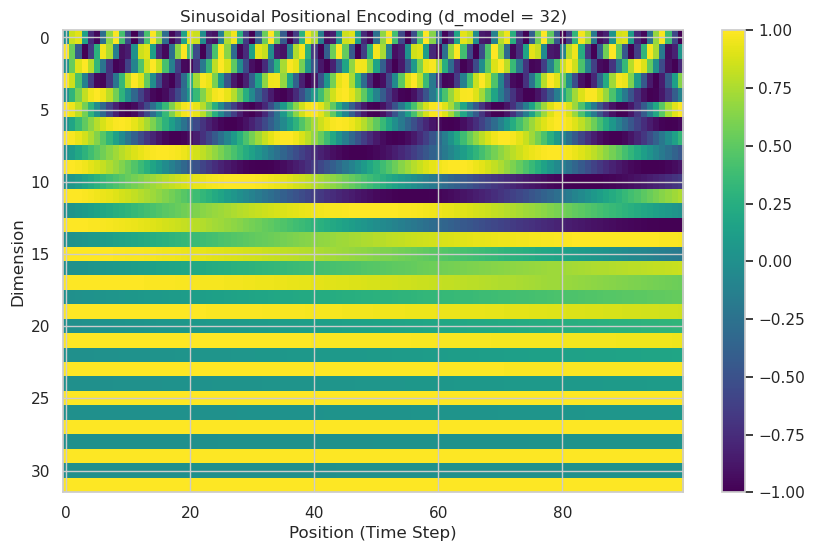

In [49]:
# Visualize for d_model=32 and first 100 positions
d_model = 32
pos_encoder = PositionalEncoding(d_model=d_model)
pe_matrix = pos_encoder.pe[0, :100].cpu().numpy()

plt.figure(figsize=(10, 6))
plt.imshow(pe_matrix.T, cmap='viridis', aspect='auto')
plt.xlabel("Position (Time Step)")
plt.ylabel("Dimension")
plt.title("Sinusoidal Positional Encoding (d_model = 32)")
plt.colorbar()
plt.show()


##  PyTorch's Built-in Transformer Modules

So far, we’ve implemented core components like Multi-Head Attention and even built GPT-like blocks from scratch.

But PyTorch also provides powerful **built-in modules** that follow the Transformer architecture — ready to use and well-optimized!


### 🔩 What are already implemented for us:

PyTorch includes the following key building blocks:

- `nn.MultiheadAttention`  
  Implements multi-head dot-product attention with all the masking and projection logic inside.

- `nn.TransformerEncoderLayer`  
  A single encoder block with attention + feed-forward + LayerNorm + dropout.

- `nn.TransformerEncoder`  
  Stacks multiple `TransformerEncoderLayer` blocks into a full encoder.

- `nn.TransformerDecoderLayer`  
  A single decoder block with masked self-attention, cross-attention, and feed-forward layers.

- `nn.TransformerDecoder`  
  Stacks multiple decoder layers for sequence generation tasks.

###  Bonus:

You can use the full model via:
```python
nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers)
